### Optimisation of Community Centre Assignment to Blood Banks in Singapore

Importing Relevent Libraries

In [1]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import clear_output
import time
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

Pulling Compiled Data

In [2]:
geodata = pd.read_csv('CommunityClubsTest-clean.csv') # Load the geospatial data for Community Centers
print(geodata)
bloodbankcoords = pd.read_csv('HSA bloodbank coordinates1.csv') # Load the geospatial data for Blood Banks
print(bloodbankcoords)
privhospcoords = pd.read_csv("Plot_of_Hospitals,_Blood_Banks_&_Community_Centers_Private_Hospital (3).csv") # Load the geospatial data for Private Hospitals
pubhospcoords = pd.read_csv("Plot_of_Hospitals,_Blood_Banks_&_Community_Centers_Public_Hospital (3).csv") # Load the geospatial data for Public Hospitals

            Y           X     Name
0    1.427493  103.792241    kml_1
1    1.354658  103.889546    kml_2
2    1.397128  103.886666    kml_3
3    1.366833  103.840668    kml_4
4    1.320799  103.747540    kml_5
..        ...         ...      ...
120  1.339973  103.737066  kml_121
121  1.386807  103.771521  kml_122
122  1.341263  103.933010  kml_123
123  1.311728  103.952223  kml_124
124  1.339360  103.727300  kml_125

[125 rows x 3 columns]
       Blood Bank  Postal Code  Latitude   Longitude
0             HSA       169078  1.281335  103.838482
1     Dhoby Ghaut       238826  1.299755  103.846084
2  Westgate Tower       608531  1.335374  103.743005
3       Woodlands       730900  1.436139  103.787195
4     One Punggol       828629  1.408468  103.905039


Preparation of Geospatial Data and Distance Computations

In [3]:
# y-coordinates/latitude of CCs, BBs and hospitals
y_coordCC = geodata['Y']
y_coordBB = bloodbankcoords['Latitude']
y_coord_privhosp = privhospcoords['Latitude']
y_coord_pubhosp = pubhospcoords['Latitude']

# x-coordinates/longitude of CCs, BBs and hospitals
x_coordCC = geodata['X']
x_coordBB = bloodbankcoords['Longitude']
x_coord_privhosp = privhospcoords['Longitude']
x_coord_pubhosp = pubhospcoords['Longitude']

print(min(y_coordCC), max(y_coordCC))
print(min(y_coordBB), max(y_coordBB))
print(min(x_coordCC), max(x_coordCC))
print(min(x_coordBB), max(x_coordBB))

print(min(y_coord_privhosp), max(y_coord_privhosp))
print(min(y_coord_pubhosp), max(y_coord_pubhosp))   
print(min(x_coord_privhosp), max(x_coord_privhosp))
print(min(x_coord_pubhosp), max(x_coord_pubhosp))

#no. of BBs
nbrblood = 5

#no. of CCs
nbrcomm = 125

#no. of private hosps
nbrprivh = 9

#no. of public hosps
nbrpubh = 10

#radius of earth
R = 6371

def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# Distance calculations between CC and BBs
distancelct=np.empty([nbrblood, nbrcomm])
for i_index in range(nbrblood):
    for j_index in range(nbrcomm):
        d_lon = deg_to_rad(x_coordBB[i_index]-x_coordCC[j_index])
        d_lat = deg_to_rad(y_coordBB[i_index]-y_coordCC[j_index])
        a = np.sin(d_lat/2)**2 +np.cos(deg_to_rad(x_coordBB[i_index])) * np.cos(deg_to_rad(x_coordCC[j_index])) * np.sin(d_lon/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distancelct[i_index,j_index] = R*c

# Distance calculation between BBs and private hospitals
distanceBB_priv = np.empty((nbrblood, nbrprivh))

for i_index in range(nbrblood):  # loop over blood banks
    for h_index in range(nbrprivh):  # loop over private hospitals
        d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_privhosp[h_index])
        d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_privhosp[h_index])
        a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_privhosp[h_index])) * np.sin(d_lon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distanceBB_priv[i_index, h_index] = R * c


distanceBB_pub = np.empty((nbrblood, nbrpubh)) # Distance calculation between BBs and public hospitals

for i_index in range(nbrblood):  # loop over blood banks
    for h_index in range(nbrpubh):  # loop over public hospitals
        d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_pubhosp[h_index])
        d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_pubhosp[h_index])
        a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_pubhosp[h_index])) * np.sin(d_lon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distanceBB_pub[i_index, h_index] = R * c

comm_coords = list(zip(x_coordCC, y_coordCC)) # Coordinates of Community Centers
bank_coords = list(zip(x_coordBB, y_coordBB)) # Coordinates of Blood Banks
privhosp_coords = list(zip(x_coord_privhosp, y_coord_privhosp)) # Coordinates of Private Hospitals
pubhosp_coords = list(zip(x_coord_pubhosp, y_coord_pubhosp)) # Coordinates of Public Hospitals

q_c = pd.read_csv('community_centres_with_blood_collection.csv')['Amount of Blood Collected'] # Amount of blood collected at each Community Center
g_b = [50, 60, 70, 65, 55]                # Min blood required at each bank
q_b = [100, 120, 130, 110, 115]            # Max capacity at each bank

1.274862657 1.45903794
1.281334976 1.43613872
103.6923202 103.959198
103.7430048 103.9050387
1.3011534 1.3419494
1.2804242 1.4250207
103.813415 103.9090373
103.7453915 103.9495701


Plotting of Geospatial Data

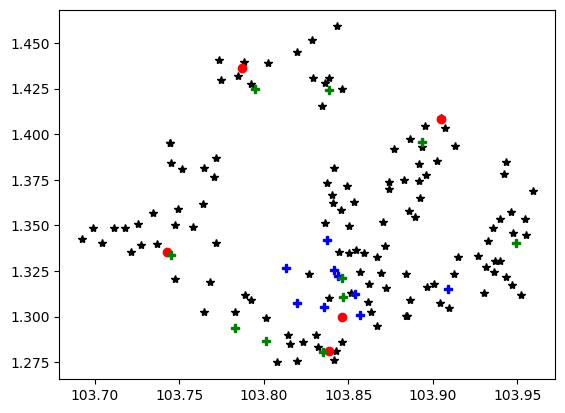

In [4]:
# 'coordlct_x' and 'coordlct_y' represent the coordinates of the facilities.
plt.plot(x_coordCC, y_coordCC, '*', color='black');
plt.plot(x_coordBB, y_coordBB, 'o', color='red');
plt.plot(x_coord_privhosp, y_coord_privhosp, 'P', color='blue')
plt.plot(x_coord_pubhosp, y_coord_pubhosp, 'P', color='green')

Gurobi Optimisation Encoding

In [5]:
#Create Model
model = gp.Model("P_Median_and_TSP")

I = list(range(nbrblood)) #Open Facilities  
J = list(range(nbrcomm)) #Facilities to be served
H_priv = list(range(nbrprivh)) # Private Hospitals          
H_pub = list(range(nbrprivh, nbrprivh + nbrpubh)) # Public Hospitals       
H = H_priv + H_pub # Combine private and public hospitals

# Define variables:
x = model.addVars(I, J, vtype=GRB.BINARY, name="assign")  # If demand from location i is served by open facility j then x_ij=1 otherwise x_ij=0
y = model.addVars(I, vtype=GRB.BINARY, name="open") # Facility i to open. y_i=0 if closed and y_i=1 if open
z = model.addVars(I, H, vtype=GRB.BINARY, name="deliver") # Deliver from blood banks to hospitals

# Minimize total distance from demands to the nearest open facilities
# Each demand location j must be assigned to exactly one facility i
model.addConstrs((gp.quicksum(x[i, j] for i in I) == 1 for j in J), name="assign_once")

# The demand from location i can only be assigned to an open facility j
model.addConstrs((x[i, j] <= y[i] for i in I for j in J), name="only_open")
model.addConstr(gp.quicksum(y[i] for i in I) == nbrblood, name="open_facilities")

# Add constraints for total blood collected
model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) >= 0.9*328, name="lower_bound_sum") # Lower bound on total blood collected, estimated using HSA data
# model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) <= 328*2, name="upper_bound_sum") #Upper bound not needed in this case, assume that each blood bank has infinite capacity
model.addConstrs((gp.quicksum(x[i, j] for j in J) <= q_b[i] * y[i] for i in I), name="capacity_constraints")  # Capacity constraints for each bank

# Fuel Cost Constraints
f_bc = 0.094*2.61 # Cost per km for blood collection (in SGD)
model.addConstr(gp.quicksum(f_bc*distancelct[i][j] * x[i, j] for i in I for j in J) <= 10000, name="budget_constraint") # Fuel cost constraint for blood collection

# # Add constraints for blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for i in I) == 1 for h in H), name="deliver_once")  # Each hospital must receive blood from exactly one bank
model.addConstrs((z[i, h] <= y[i] for i in I for h in H), name="only_open_delivery")  # Blood can only be delivered from open banks 
model.addConstrs((gp.quicksum(z[i, h] for i in I) <= q_c[h] for h in H), name="delivery_capacity")  # Capacity constraints for each hospital

# Add constraints for maximum blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for h in H) <= q_c[i] for i in I), name="max_blood_delivery")  # Maximum blood delivery to hospitals

# Add binary variables for TSP
# u[k, i, j] = 1 if blood bank k travels from collection center
u = model.addVars(nbrblood, nbrcomm, nbrcomm, vtype=GRB.BINARY, name="route")
for k in range(nbrblood):
    for i in range(nbrcomm):
        model.addConstr(gp.quicksum(u[k, i, j] for j in range(nbrcomm) if j != i) == x[k, i])
        model.addConstr(gp.quicksum(u[k, j, i] for j in range(nbrcomm) if j != i) == x[k, i])

# Add continuous variables for MTZ
mtz = model.addVars(nbrblood, nbrcomm, vtype=GRB.CONTINUOUS, lb=0, ub=nbrcomm, name="mtz")
# Add MTZ constraints to prevent subtours
for k in range(nbrblood):
    for i in range(1, nbrcomm):
        for j in range(1, nbrcomm):
            if i != j:
                model.addConstr(mtz[k, i] - mtz[k, j] + nbrcomm * u[k, i, j] <= nbrcomm - 1)

# Each blood bank to have at least one collection center assigned (this is optional, makes the problem significantly more complex)
# model.addConstrs((gp.quicksum(x[i, j] for j in J) >= 1 for i in I), name="min_one_cc_per_bank")

# Set the objective function to minimize the total distance
model.setObjective(
    gp.quicksum(x[i, j] * distancelct[i][j] for i in I for j in J) +
    gp.quicksum(z[i, h] * distanceBB_priv[i][h] for i in I for h in H_priv) +
    gp.quicksum(z[i, h] * distanceBB_pub[i][h - nbrprivh] for i in I for h in H_pub)+
    gp.quicksum(u[k, i, j] * np.linalg.norm(np.array(comm_coords[i]) - np.array(comm_coords[j]))
               for k in range(nbrblood) for i in range(nbrcomm) for j in range(nbrcomm) if i != j),
    GRB.MINIMIZE
)

# Set parameters for the model
model.setParam('TimeLimit', 3600)  # Set time limit to 60 minutes, total allowed run time is 2 hours

# Callback function to track convergence
convergence_times = []
convergence_objs = []

def convergence_callback(model, where):
    if where == gp.GRB.Callback.MIPSOL:
        time = model.cbGet(gp.GRB.Callback.RUNTIME)
        obj = model.cbGet(gp.GRB.Callback.MIPSOL_OBJ)
        convergence_times.append(time)
        convergence_objs.append(obj)

# When calling optimize, pass the callback:
model.optimize(convergence_callback)
model.optimize()

if model.status in [gp.GRB.OPTIMAL, gp.GRB.TIME_LIMIT, gp.GRB.SUBOPTIMAL]:
    print(f"Best objective value found: {model.objVal}")

    assignments = {i: [] for i in I}
    for i in I:
        for j in J:
            if x[i, j].X > 0.5:
                assignments[i].append(j)
    
    plt.figure(figsize=(8, 5))
    plt.plot(convergence_times, convergence_objs, marker='o')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Best Objective Value')
    plt.title('Convergence of Gurobi Optimizer')
    plt.grid(True)
    plt.show()

else:
    print("No feasible solution found. Skipping plotting.")


Set parameter Username
Set parameter LicenseID to value 2668971
Academic license - for non-commercial use only - expires 2026-05-21
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  3600

Optimize a model with 78406 rows, 79475 columns and 389265 nonzeros
Model fingerprint: 0xd9955365
Variable types: 625 continuous, 78850 integer (78850 binary)
Coefficient statistics:
  Matrix range     [4e-03, 8e+02]
  Objective range  [8e-04, 2e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+04]
Presolve removed 767 rows and 730 columns
Presolve time: 0.42s
Presolved: 77639 rows, 78745 columns, 386155 nonzeros
Variable types: 620 continuous, 78125 integer (78125 binary)
Deterministic concurrent LP optimizer: primal and dual

AttributeError: Unable to retrieve attribute 'X'

Plotting Convergence Graphs and Final Solutions

AttributeError: Unable to retrieve attribute 'X'

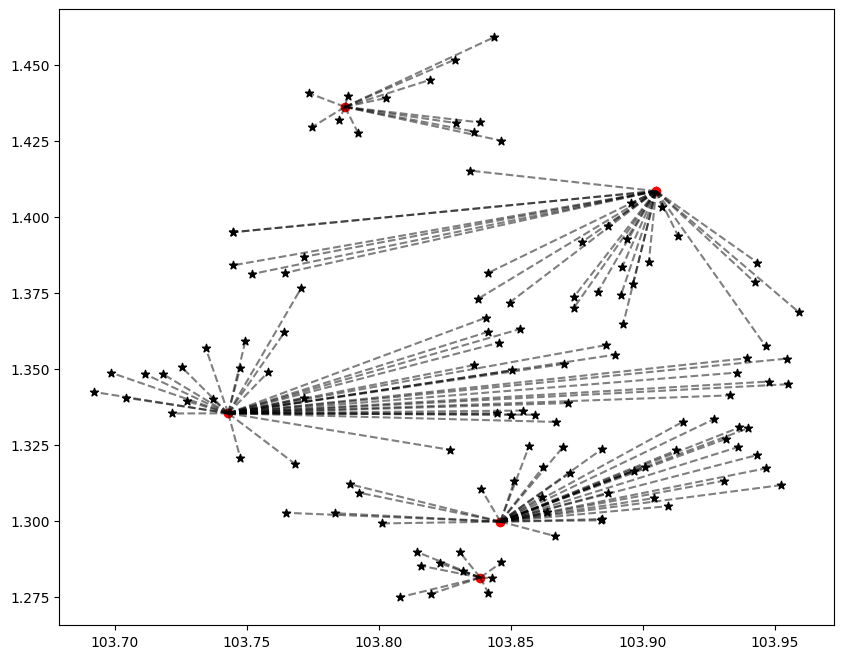

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 8))

# Plot community centers and blood banks
plt.scatter([c[0] for c in comm_coords], [c[1] for c in comm_coords], c='black', marker='*', label='Community Centers')
plt.scatter([b[0] for b in bank_coords], [b[1] for b in bank_coords], c='red', marker='o', label='Blood Banks')

# Draw assignment lines (gray dashed)
for k in I:
    for j in assignments[k]:
        bx, by = bank_coords[k]
        cx, cy = comm_coords[j]
        plt.plot([bx, cx], [by, cy], 'k--', alpha=0.5)

# Optionally, plot TSP routes for each blood bank
def extract_tsp_route(u, k, nbrcoll):
    # Simple greedy extraction (not guaranteed to be optimal order, but shows the route)
    route = []
    visited = set()
    # Find start node (assigned to k)
    for i in range(nbrcoll):
        if sum(u[k, i, j].X for j in range(nbrcoll) if j != i) > 0.5:
            current = i
            break
    route.append(current)
    while len(route) < len(assignments[k]):
        for j in range(nbrcoll):
            if j != current and u[k, current, j].X > 0.5 and j not in visited:
                route.append(j)
                visited.add(current)
                current = j
                break
        else:
            break
    return route

colors = ['orange', 'green', 'purple', 'brown', 'magenta']
for k in I:
    if assignments[k]:
        route = extract_tsp_route(u, k, nbrcomm)
        if route:
            path = [bank_coords[k]] + [comm_coords[j] for j in route] + [bank_coords[k]]
            path_x, path_y = zip(*path)
            plt.plot(path_x, path_y, color=colors[k % len(colors)], linewidth=2, label=f'TSP Route BB {k+1}')

plt.title("Optimized Assignments and TSP Routes for Blood Banks")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()